# ARMA
[大图](arma.html), [下载](origin_files/arma.ipynb)

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pylab as plt

In [2]:
df = pd.read_csv('http://www.guofei.site/StatisticsBlog/datasets/AirPassengers.csv',header=0,encoding='utf-8', index_col=0)
df.index.name='date'
df.index = pd.to_datetime(df.index)  # 将字符串索引转换成时间索引
ts = df['NumPassengers']  # 生成pd.Series对象
ts.head()

date
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: NumPassengers, dtype: int64

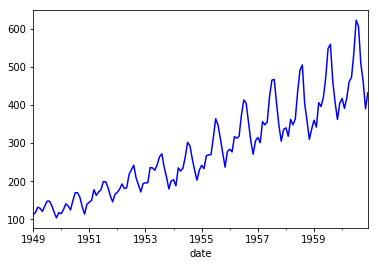

In [3]:
def draw_ts(timeSeries):
    f = plt.figure(facecolor='white')
    timeSeries.plot(color='blue')
    plt.show()
draw_ts(ts)

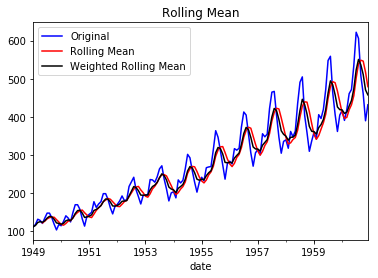

In [4]:
# 移动平均图
def draw_trend(timeSeries, size):
    f = plt.figure(facecolor='white')
    # 对size个数据进行移动平均
    rol_mean = timeSeries.rolling(window=size).mean()
    # 对size个数据进行加权移动平均
    rol_weighted_mean = timeSeries.ewm( span=size).mean()
    timeSeries.plot(color='blue', label='Original')
    rol_mean.plot(color='red', label='Rolling Mean')
    rol_weighted_mean.plot(color='black', label='Weighted Rolling Mean')
    plt.legend(loc='best')
    plt.title('Rolling Mean')
    plt.show()
draw_trend(ts, size=5)

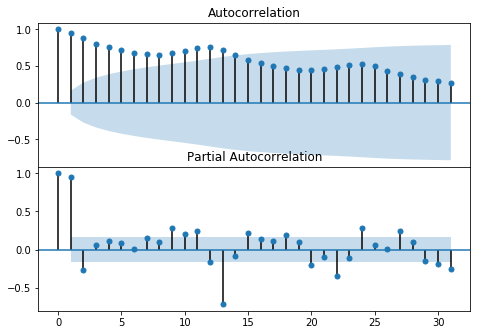

In [5]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# 自相关和偏相关图
def draw_acf_pacf(ts, lags=31):
    f,ax=plt.subplots(2,1)
    plot_acf(ts, lags=lags, ax=ax[0])
    plot_pacf(ts, lags=lags, ax=ax[1])
    plt.subplots_adjust(0,0,1,1,0,0)
    plt.show()
draw_acf_pacf(ts)

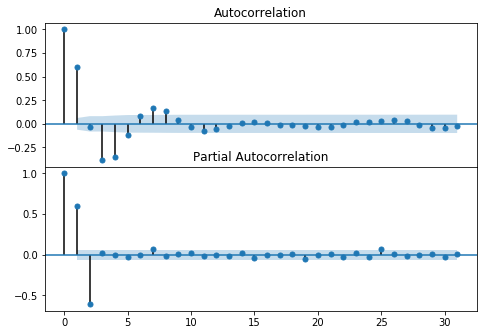

In [6]:
from statsmodels.tsa.arima_process import arma_generate_sample
ts_rv=arma_generate_sample(ar=[0.3,-0.3,0.2],ma=[1],nsample=1000)
draw_acf_pacf(ts_rv)

||AR(p)|MA(q)|ARMA(p,q)|
|--|--|--|--|
|ACF|拖尾|q期后截尾|拖尾|
|PACF|p期后截尾|拖尾|拖尾|

In [7]:
from statsmodels.tsa.stattools import adfuller

'''
　　Unit Root Test
   The null hypothesis of the Augmented Dickey-Fuller is that there is a unit
   root, with the alternative that there is no unit root. That is to say the
   bigger the p-value the more reason we assert that there is a unit root
'''
def testStationarity(ts):
    dftest = adfuller(ts)
    # 对上述函数求得的值进行语义描述
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    return dfoutput

testStationarity(ts)
# p-value>0.05,证明序列非平稳

Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64

H0：存在单位根，此时非平稳  
案例汇中p较大，因此不能拒绝原假设。认为时间序列不平稳

## 平稳性处理
- 对数变换
- 差分
- 趋势+周期分解


### 1. 对数变换

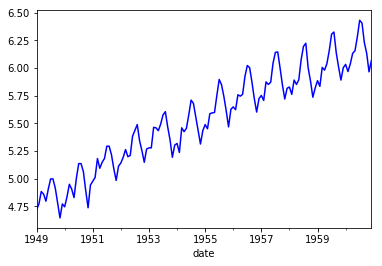

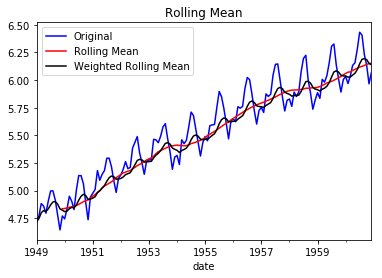

In [8]:
ts_log = np.log(ts)
draw_ts(ts_log)
draw_trend(ts_log, 12)

### 2. 差分法

In [9]:
diff_12 = ts_log.diff(12)
diff_12.dropna(inplace=True)
diff_12_1 = diff_12.diff(1)
diff_12_1.dropna(inplace=True)
testStationarity(diff_12_1)

Test Statistic                  -4.443325
p-value                          0.000249
#Lags Used                      12.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
dtype: float64

因此使用diff_12_1来做ARMA

### 3. 趋势分解

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model="additive")
# model="additive" 加法模型
# model='multiplicative' 乘法模型


trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

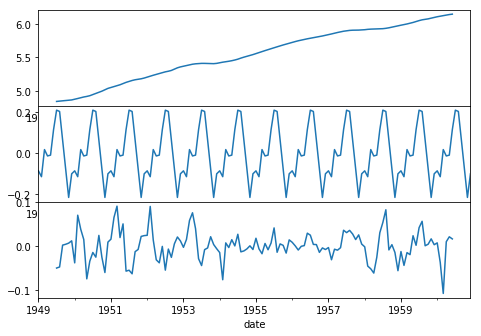

In [11]:
f=plt.figure()
ax1 = f.add_subplot(311)
trend.plot()
ax2 = f.add_subplot(312)
seasonal.plot()
ax3 = f.add_subplot(313)
residual.plot()
plt.subplots_adjust(0,0,1,1,0,0)
plt.show()

## ARMA
(我们选用移动平均和差分法生成的平稳数据)

In [12]:
rol_mean = ts_log.rolling(window=12).mean()
rol_mean.dropna(inplace=True)
ts_diff_1 = rol_mean.diff(1)
ts_diff_1.dropna(inplace=True)
testStationarity(ts_diff_1)

Test Statistic                  -2.709577
p-value                          0.072396
#Lags Used                      12.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64

不显著，因此再次diff

In [13]:
ts_diff_2 = ts_diff_1.diff(1)
ts_diff_2.dropna(inplace=True)
testStationarity(ts_diff_2)

Test Statistic                  -4.443325
p-value                          0.000249
#Lags Used                      12.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
dtype: float64

In [14]:
from statsmodels.tsa.arima_model import ARMA
model = ARMA(ts_diff_2, order=(1, 1)) #order=(1,1,1)就是ARIMA
result_arma = model.fit( disp=-1, method='css')

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [15]:
result_arma.aic
result_arma.arparams
result_arma.maparams

array([-0.54041223])

### 预测

In [16]:
predict_ts=result_arma.predict()

In [17]:
predict_ts = result_arma.predict()
# 一阶差分还原
diff_shift_ts = ts_diff_1.shift(1)
diff_recover_1 = predict_ts.add(diff_shift_ts)
# 再次一阶差分还原
rol_shift_ts = rol_mean.shift(1)
diff_recover = diff_recover_1.add(rol_shift_ts)
# 移动平均还原
rol_sum = ts_log.rolling(window=11).sum()
rol_recover = diff_recover*12 - rol_sum.shift(1)
# 对数还原
log_recover = np.exp(rol_recover)
log_recover.dropna(inplace=True)

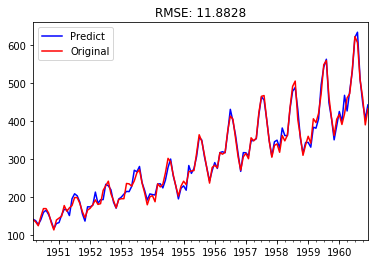

In [18]:
ts = ts[log_recover.index]  # 过滤没有预测的记录
plt.figure(facecolor='white')
log_recover.plot(color='blue', label='Predict')
ts.plot(color='red', label='Original')
plt.legend(loc='best')
plt.title('RMSE: %.4f'% np.sqrt(sum((log_recover-ts)**2)/ts.size))
plt.show()

参考资料：https://www.cnblogs.com/foley/p/5582358.html

# Box - Jenkins建模流程 

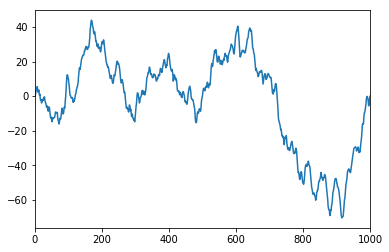

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
df = pd.read_csv('ARIMA([0.6],1,0).csv', index_col=0)
ts = df['x']
ts.plot()
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


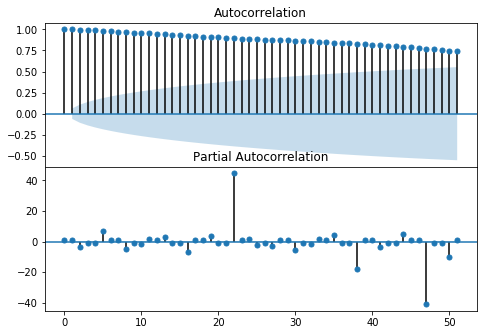

In [20]:
# 自相关和偏相关图
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
f,ax=plt.subplots(2,1)
plot_acf(ts, lags=51, ax=ax[0])
plot_pacf(ts, lags=51, ax=ax[1])
plt.subplots_adjust(0,0,1,1,0,0)
plt.show()

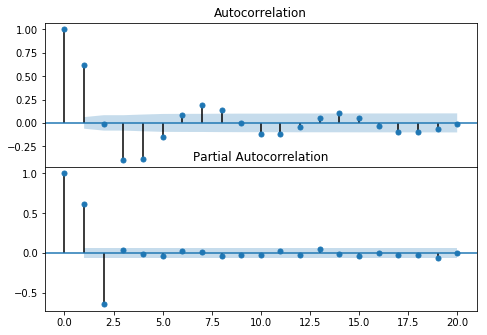

In [21]:
from statsmodels.tsa.arima_process import arma_generate_sample
ts_rv=arma_generate_sample(ar=[0.3,-0.3,0.2],ma=[1],nsample=1000)
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
f,ax=plt.subplots(2,1)
plot_acf(ts_rv, lags=20, ax=ax[0])
plot_pacf(ts_rv, lags=20, ax=ax[1])
plt.subplots_adjust(0,0,1,1,0,0)
plt.show()

### 第一步：检验平稳性

In [22]:
from statsmodels.tsa.stattools import adfuller
dftest=adfuller(ts, autolag='AIC') # 返回统计量、p-value 等
dftest
# p-value>0.05, 说明ts非平稳

(-1.6433898010455334,
 0.46049007747238885,
 1,
 998,
 {'1%': -3.4369193380671001,
  '10%': -2.5683143032357298,
  '5%': -2.8644403834525169},
 2807.3911597685606)

### 第二步：若时间序列非平稳，进行差分，使其变的平稳


In [23]:
ts_diff=ts.diff(1)[1:]
adfuller(ts_diff, autolag='AIC')
# p-value<0.05,说明序列平稳，可以使用统计时序模型进行建模

(-14.921710180719526,
 1.4083893588071126e-27,
 0,
 998,
 {'1%': -3.4369193380671001,
  '10%': -2.5683143032357298,
  '5%': -2.8644403834525169},
 2804.4647207098624)

### 第三步：模型识别

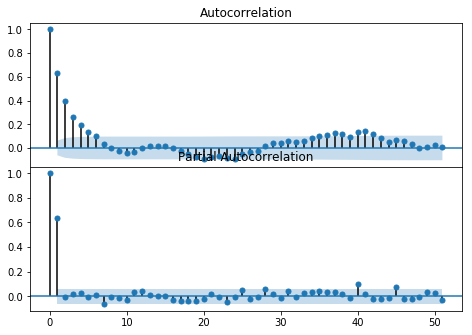

In [24]:
# 自相关和偏相关图
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
f,ax=plt.subplots(2,1)
plot_acf(ts_diff, lags=51, ax=ax[0])
plot_pacf(ts_diff, lags=51, ax=ax[1])
plt.subplots_adjust(0,0,1,1,0,0)
plt.show()

### 第四步： 模型拟合

In [25]:
import statsmodels.tsa.api as smt
arima_1 = smt.ARIMA(df,order=(1,1,0)).fit()
print(arima_1.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.x   No. Observations:                  999
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -1443.650
Method:                       css-mle   S.D. of innovations              1.026
Date:                Mon, 11 Jun 2018   AIC                           2893.300
Time:                        16:22:36   BIC                           2908.020
Sample:                             1   HQIC                          2898.895
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0032      0.089      0.036      0.971      -0.171       0.177
ar.L1.D.x      0.6345      0.024     25.969      0.000       0.587       0.682
                                    Roots           

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


### 第五步： 模型检验

In [26]:
from statsmodels.stats.diagnostic import acorr_ljungbox
lags=5
rdtest = acorr_ljungbox(arima_1.resid,lags=lags)
pd.DataFrame({'test statistic':rdtest[0],'p-value':rdtest[1]},index=np.arange(lags)+1)
# p-value>0.05,不能拒绝原假设，认为是白噪声序列

,p-value,test statistic
1,0.904764,0.014315
2,0.861410,0.298370
3,0.950762,0.347998
4,0.899331,1.067904
5,0.953956,1.101668


### 第六步： 模型预测

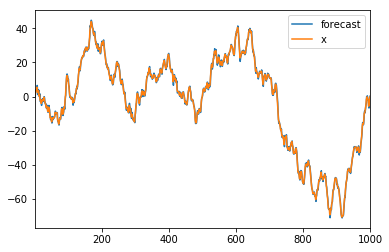

In [27]:
arima_1.plot_predict(plot_insample=True,dynamic=False)

In [28]:
df_predict=arima_1.predict(start=1,end=998,exog=None,typ='levels',dynamic=False)
# 因为做了一阶差分，因此start=1，
# typ='levels' 表示预测差分以前的ts
# typ='linear' 猜测是无视了差分（不确定）

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


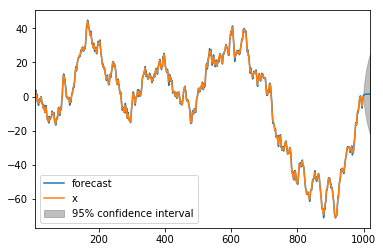

In [29]:
arima_1.forecast(steps=10,alpha=0.05)
arima_1.plot_predict(start=10,end=1020,plot_insample=True)

In [30]:
df_forecast=arima_1.forecast(steps=3,alpha=0.05) 
pd.concat([pd.DataFrame(df_forecast[0], columns=['点估计']),
                       pd.DataFrame(df_forecast[1], columns=['标准差']),
                       pd.DataFrame(df_forecast[2], columns=['区间估计下限(95%)','区间估计下限(95%)'])],
                      axis=1)

,点估计,标准差,区间估计下限(95%),区间估计下限(95%)
0,0.459953,1.026237,-1.551435,2.471340
1,0.809223,1.966390,-3.044831,4.663276
2,1.031987,2.869979,-4.593068,6.657042


In [31]:
df_forecast=arima_1.forecast(steps=3,alpha=0.05) 
pd.DataFrame({'点估计':df_forecast[0],'标准差':df_forecast[1],
              '区间估计下限(95%)':df_forecast[2][:,0],
             '区间估计上限(95%)':df_forecast[2][:,1]})

,区间估计上限(95%),区间估计下限(95%),标准差,点估计
0,2.471340,-1.551435,1.026237,0.459953
1,4.663276,-3.044831,1.966390,0.809223
2,6.657042,-4.593068,2.869979,1.031987
